In [1]:
import pandas as pd

#Preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures

# Pipeline
from sklearn.pipeline import Pipeline   # Sequentially apply a list of transformations
from sklearn.compose import ColumnTransformer # Applies in parallel transformations to columns
from sklearn.preprocessing import FunctionTransformer # it makes functions compatible with scikit-learn pipelines

# Grid search 
from sklearn.model_selection import GridSearchCV

# pipeline visualization (only if sklearn version = 0.23.1)
from sklearn import set_config
set_config(display='diagram')

from sklearn.neighbors import KNeighborsClassifier

In [2]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/titanic.csv'
titanic = pd.read_csv(url,index_col='PassengerId')
titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Numerical features:

- Age
- Fare
- Pclass (passenger class)
- SibSp (number of siblings / spouses aboard the Titanic)
- Parch (number of parents / children aboard the Titanic)

Categorical features:

- Sex
- Ticket
- Cabin
- Embarked (Port of Embarkation: C, Q, and S)

In [3]:
titanic.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [4]:
titanic.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [5]:
titanic.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [6]:
titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
titanic.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
titanic.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [9]:
titanic.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

## Custom transformers: creating new features

Often, you will want to convert an existing Python function into a transformer to assist in data cleaning or processing. You can implement a transformer from an arbitrary function with FunctionTransformer.

$\textbf{Title feature:}$ Let's write a function that extract the title (Mr, Mrs, Miss, Dr, etc) from the name

In [10]:
titanic.Name.head(30)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
11                      Sandstrom, Miss. Marguerite Rut
12                             Bonnell, Miss. Elizabeth
13                       Saundercock, Mr. William Henry
14                          Andersson, Mr. Anders Johan
15                 Vestrom, Miss. Hulda Amanda Adolfina
16                     Hewlett, Mrs. (Mary D Kingcome) 
17                                 Rice, Master. Eugene
18                         Williams,

In [11]:
# Title feature
titles = titanic.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
titles

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object

<AxesSubplot:>

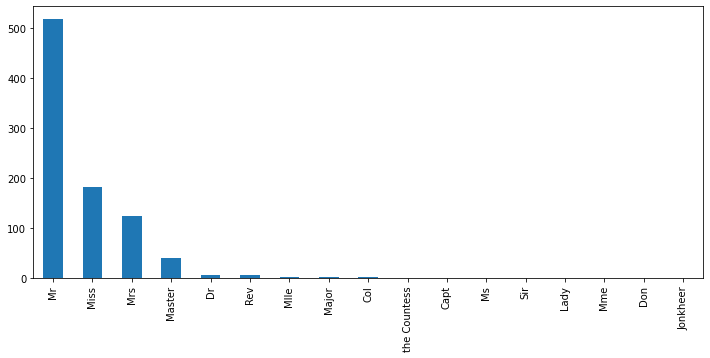

In [12]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

In [13]:
# replace the less common titles with 'Other'
most_common_titles = titles.value_counts().head(6).index.to_list()
titles[~titles.isin(most_common_titles)] = 'Other'

<AxesSubplot:>

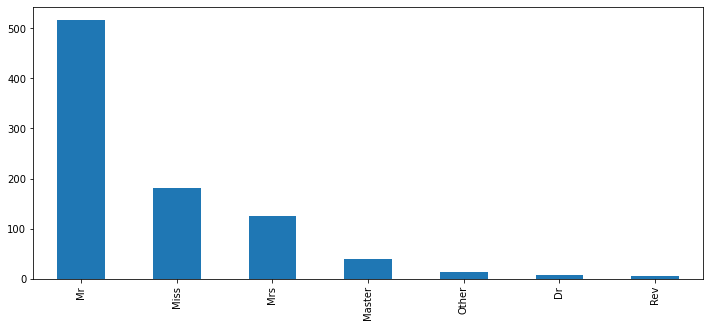

In [14]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

In [15]:
most_common_titles

['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']

In [16]:
def get_title(df):
    dataframe = df.copy() # we do not want to modify the original dataframe
    dataframe['Title'] = dataframe.Name.apply(lambda name:name.split(',')[1].split('.')[0].strip())
    dataframe.loc[~dataframe.Title.isin(dataframe['Title'].value_counts().head(6).index.to_list()),'Title'] = 'Other'
    return dataframe

In [17]:
# check that it works
get_title(titanic)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss


In [18]:
# check that it works
get_title(titanic).Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: Title, dtype: int64

In [19]:
# family size
family_size = titanic.SibSp+titanic.Parch+1
family_size

PassengerId
1      2
2      2
3      1
4      2
5      1
      ..
887    1
888    1
889    4
890    1
891    1
Length: 891, dtype: int64

In [20]:
def get_family_size(dataframe):
    df = dataframe.copy()
    df['Family_size'] = df.SibSp + df.Parch + 1
    return df

In [21]:
# check that it works
get_family_size(titanic)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4


To build a transformer that applies our two functions get_title and get_family_size in a a pipeline, use FunctionTransformer.

In [22]:
# Functions for the pipeline
family_size_processor = FunctionTransformer(get_family_size)
title_processor = FunctionTransformer(get_title)

In [23]:
family_size_processor.fit_transform(titanic)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4


In [24]:
title_processor.fit_transform(titanic)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss


## Column transformers and pipelines

We often need to apply different sets of tranformers to different groups of columns. This is where ColumnTransformer comes in. We'll create a transformer for the numerical featues, a transformer for the categorical features and a transformer por the ordinal features.

In [25]:
num_features = ['Pclass','Age','Fare','Family_size'] #numerical veatures 
num_processor = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),('scaler',MinMaxScaler())])
num_processor

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [26]:
cat_features = ['Sex','Embarked','Title']
cat_processor = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder())])
cat_processor

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder())])

In [27]:
features_processor = ColumnTransformer(transformers=
    [('numerical processor',num_processor,num_features),
     ('categorical features)',cat_processor,cat_features)],
      remainder='drop') # drop Name, SibSp, Parch, Cabin, Ticket
features_processor

ColumnTransformer(transformers=[('numerical processor',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Pclass', 'Age', 'Fare', 'Family_size']),
                                ('categorical features)',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 ['Sex', 'Embarked', 'Title'])])

In [28]:
titanic.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [29]:
# classifier 
knn = KNeighborsClassifier()

In [30]:
# classification pipeline 
pipe = Pipeline(steps=[('get_title',title_processor),('get_family_size',family_size_processor),
                      ('feature_processor',features_processor),('poly_features',PolynomialFeatures()),
                      ('classifier',knn)])
pipe

Pipeline(steps=[('get_title',
                 FunctionTransformer(func=<function get_title at 0x000002608529F790>)),
                ('get_family_size',
                 FunctionTransformer(func=<function get_family_size at 0x00000260852CA310>)),
                ('feature_processor',
                 ColumnTransformer(transformers=[('numerical processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Family_size']),
                                                 ('categorical features)',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('poly_features', PolynomialFeatures()),
                ('classifier', KNeighborsClassifier())])

In [31]:
# grid search (degree of the poly features, n_neighbors, weights)

param_dic = {'classifier__n_neighbors':list(range(1,30)),
            'classifier__weights':['uniform','distance'],
            'poly_features__degree':[1,2]}
grid =  GridSearchCV(pipe,param_dic,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)

In [32]:
# feature matrix X and target vector y
X = titanic.drop('Survived',axis=1)
y = titanic.Survived

In [33]:
X.head(1)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [34]:
grid.fit(X,y)

Fitting 5 folds for each of 116 candidates, totalling 580 fits


C:\Users\rebec\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('get_title',
                                        FunctionTransformer(func=<function get_title at 0x000002608529F790>)),
                                       ('get_family_size',
                                        FunctionTransformer(func=<function get_family_size at 0x00000260852CA310>)),
                                       ('feature_processor',
                                        ColumnTransformer(transformers=[('numerical '
                                                                         'processor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          Min...
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title'])])),
                                       ('poly_features', PolynomialFeatures()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29],
                         'classifier__weights': ['uniform', 'distance'],
                         'poly_features__degree': [1, 2]},
             scoring='accuracy', verbose=1)

In [35]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
grid.best_params_

{'classifier__n_neighbors': 1,
 'classifier__weights': 'uniform',
 'poly_features__degree': 1}

In [37]:
# best pipe
best_pipe = grid.best_estimator_

In [38]:
# Would I have survived the Titanic disaster 
passenger = {'Pclass':[1],'Name':['Bryan, Rebecca'],'Sex':['female'],'Age':[21],'SibSp':[1],'Parch':[0], 'Ticket':['blahblah'],'Fare':[100],'Cabin': ['something'],'Embarked':['S']}
passenger = pd.DataFrame(passenger)
passenger

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,"Bryan, Rebecca",female,21,1,0,blahblah,100,something,S


In [39]:
best_pipe.predict(passenger)

ValueError: Found unknown categories ['Rebecca'] in column 2 during transform